## Monte Carlo Locating

The travel time to locate a part in a hospital facility consists of three movements.
- Variable X is the time to travel to the correct aisle.
- Variable Y is the time to travel to the correct location along the aisle.
- Variable Z is the time to find the correct location on the shelves.

Assume that the distributions of X, Y, and Z are as follows:


- X ∼ Uniforms with minimum 25 and maximum 50 seconds
- Y ∼ Triangular with minimum 10, maximum 25 seconds, and most likely travel time of 15 seconds.
- Z ∼ Truncated-normal with minimum 2, mean 6, and standard deviation 2 seconds.

In [ ]:
install.packages('truncnorm')

In [ ]:
install.packages('triangle')

In [4]:
library(truncnorm)
library(triangle)

set.seed(123)

sim = 100000

x <- runif(sim, 25, 50)
y <- rtriangle(sim, a = 10, b = 25, c = 15)
z <- rtruncnorm(sim, a = 2, mean = 6, sd = 2)

time <- x + y + z

In [5]:
mean(time)
sd(time)

[1] 60.26944

[1] 8.072481

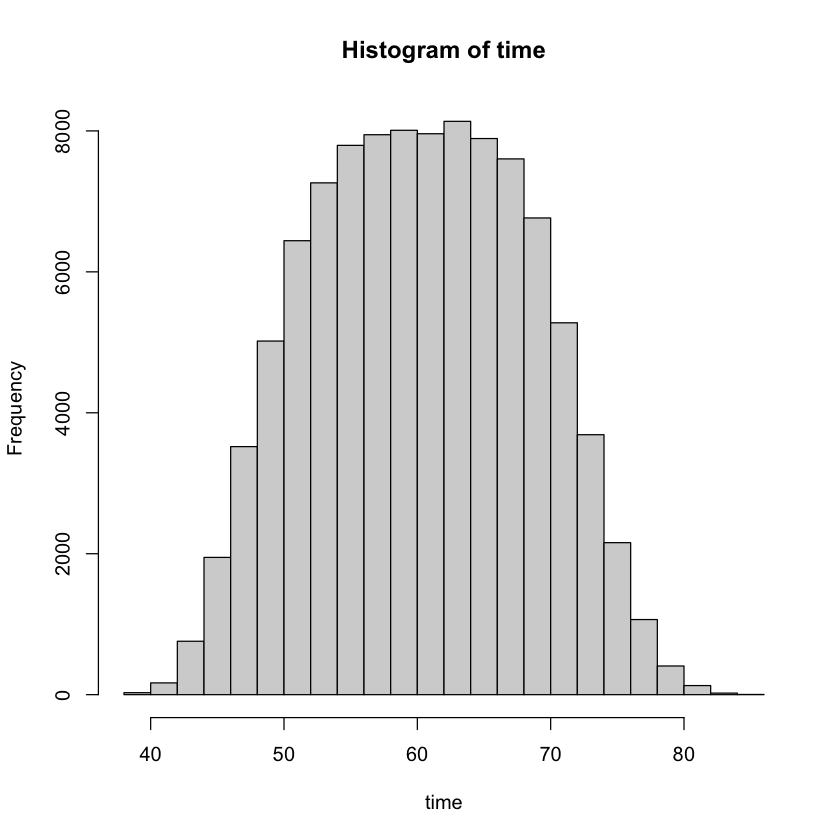

In [6]:
hist(time)

[1] 0.1275

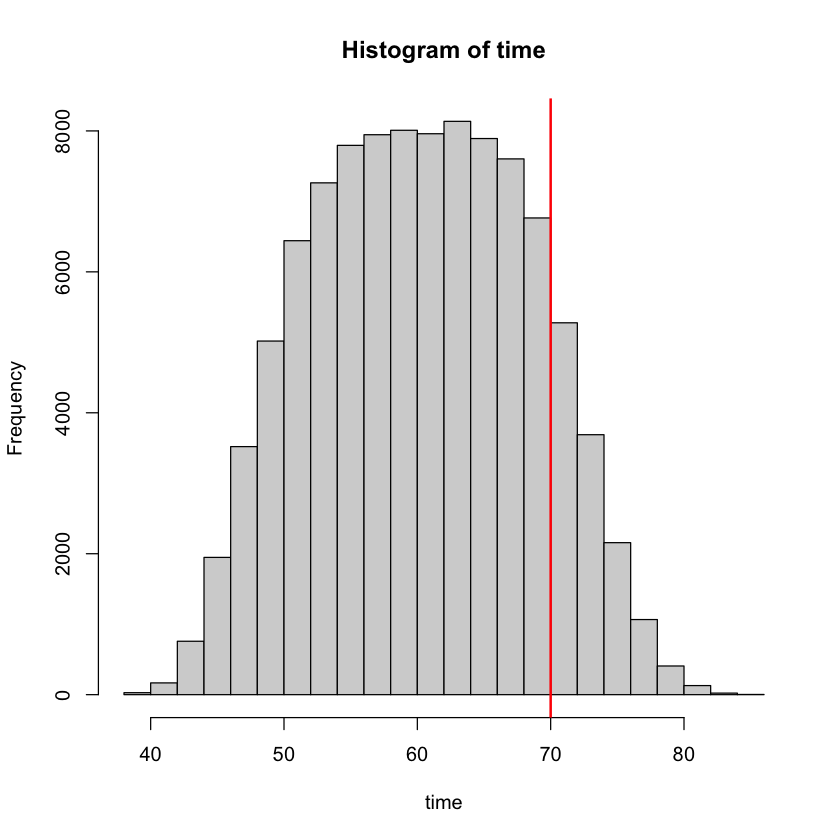

In [10]:
mean(time > 70)
hist(time)
abline(v = 70, col = "red", lwd = 2)

## Pseudorandom Number Generation
Simulation models depend on generating random numbers for the simulations to be effective. One way to generate those numbers is with the Linear Congruential Generator (LCG), which we will calculate mathematically for a few numbers before computing the rest of series in R. 

LCG is defined by the recursive relationship:

$R_(i+1) = (aR_i + c) \bmod m$

Where
- $R_0$ is the seed of the sequence
- a is the constant multiplier
- c in the increment
- m is the modulus
- i is the series (0, 1, 2...)

Then to compute the pseudorandom uniform number we can use:

$U_i = \frac{R_i}{m}$

Consider an LCG with parameters (m = 200, a = 17, c = 1, $R_0 = 5$).

We can calculate the first three pseudorandom numbers as follows:

$R_1 = (17(5) + 1) \bmod 200$

$U_1 = \frac{R_i}{200} = 0.43$

$R_2 = (17(86) + 1) \bmod 200$

$U_2 = \frac{63}{200} = 0.315$

$R_3 = (17(63) + 1) \bmod 200 = 72$

$U_3 = \frac{72}{200} = 0.36$

Our first three pseudorandom numbers are (0.43, 0.315, 0.36)

We can compute this in R by populating this algorithm into a function:

In [13]:
# Define a function LCG to hold the algorithm
# Accepts a parameter n for how many random numbers to generate
lcg.rand <- function(n) {
    U <- vector(length = n)
    
    m <- 200
    a <- 17
    c <- 1
    
    R = 5
    
    # Loop n times applying algorithm over the seed
    for (i in 1:n) { 
        R <- (a * R + c) %% m
        U[i] <- R / m
    }
    return(U)
}

Now we can compute the first 20 pseudorandom numbers and confirm the first three match our manual calculations above:

In [14]:
lcg.rand(20)

[1] 0.430 0.315 0.360 0.125 0.130 0.215 0.660 0.225 0.830 0.115 0.960 0.325
[13] 0.530 0.015 0.260 0.425 0.230 0.915 0.560 0.525

## Monte Carlo Product Development

A healthcare company needs to decide whether to conduct clinical trials and seek FDA approval for a newly developed drug.

Suppose that analysts have made the following assumptions:
- R&D costs: Triangular(min= \\$500, max = \\$850, most likely = \\$750) in millions of dollars
- Clinical trials costs: Uniform(min= \\$135, max = \\$170) in millions of dollars
- Market size: Normal(mean = 2,200,000, sd = 250,000)
- Market share in year 1: Uniform(min = 5%, max = 10%)
- Discount Rate = 0.08

All other data are considered constant.
- Market size growth = 5% per year
- Market share growth = 10% per year
- Monthly revenue/prescription = \\$150
- Monthly variable cost/prescription = \\$50

This problem gives us a mix of stochastic (random) and non-stochastic variables. We can identify our non-stochastic variables first, as well as some other constant values such as the simulation number, discount rate, and timeframe in years.

In [1]:
set.seed(123)

# Non-stochastic parameters
marketSizeGrowth = 0.05
marketShareGrowth = 0.1
unitRevenue = 150
unitCost = 50

num_sim = 1000

# Data
year = 5
discountRate = 0.08


This question requires us to examine both annual and net present profit. Here we will define models for both as functions.

The annual profit is a function of our market size, growth, share, and share growth over our time frame. From these we can calculate our annual revenues and costs to get our profit.

Net present profit is calculated with our calculated profit and the discount rate.

In [2]:
# Annual Profit model
AnnualProfit = function(year, marketSize, marketSizeGrowth, marketShare, marketShareGrowth, unitRevenue, unitCost){
    marketSize = marketSize*(1+marketSizeGrowth)^(year-1)
    marketShare = marketShare*(1+marketShareGrowth)^(year-1)
    sale = marketSize*marketShare
    annualRevenue = 12*sale*unitRevenue
    annualCost = 12*sale*unitCost
    
    return(annualRevenue-annualCost)
}

# Net Present Profit model
netPresentProfit <- function(discountRate, profit, year){
  netProfit <- 0
  for(t in 1:year) {
    netProfit <- netProfit + profit[t]/(1+discountRate)^t
  }
  return(netProfit)
}

Determining our profit and net present value is accomplished by looping over our stochastic variables (which are individually performing a single simulation), doing the profit calculations, and adding the result to a simulation vector. This loop is repeated 1000 times as specified in our `num_sim` variable.

In [3]:
library(triangle)

# Create an empty vector called simulated_npv
simulated_npv <- c()

# Loop through stochastic variables num_sim number of times 

for(i in 1:num_sim){
  marketSize = rnorm(1, 2200000, 250000)
  marketShare = runif(1, .05, .1)

  # Project Cost
  rdCost = rtriangle(1, a = 500000000, b = 850000000, c = 750000000)
  
  clinicalCost = rnorm(1, 135000000, 170000000)
  
  projectCost = rdCost + clinicalCost

  # Profit calculations
  
  profit <- AnnualProfit(1:year, marketSize, marketSizeGrowth, marketShare, marketShareGrowth, unitRevenue, unitCost)
  
  npvProfit <- netPresentProfit(discountRate, profit, year)
  
  npv = npvProfit-projectCost
  
  simulated_npv <- c(simulated_npv, npv)
}

Finally, we can take the mean and standard variation of this vector to give us our net-present value estimates. The standard deviation is larger than our mean, suggesting that the simulated data are highly variable and this is potentially a risky product decision.  

In [16]:
mean_npv <- mean(simulated_npv)
formatted_mean_npv <- paste0("$", format(round(mean_npv, 2), big.mark = ","))
cat("The mean NPV is:", formatted_mean_npv, "\n")

sd_npv <- sd(simulated_npv)
formatted_sd_npv <- paste0("$", format(round(sd_npv, 2), big.mark = ","))
cat("The NPV standard deviation is:", formatted_sd_npv)

The mean NPV is: $221,301,747 
The NPV standard deviation is: $305,767,922

We can examine that risk more closely by calculating and plotting the mean of our simulated values below 0, indicating a negative return. As we can see, there is a 23.8% chance of this product investment having a negative return. 

[1] 0.238

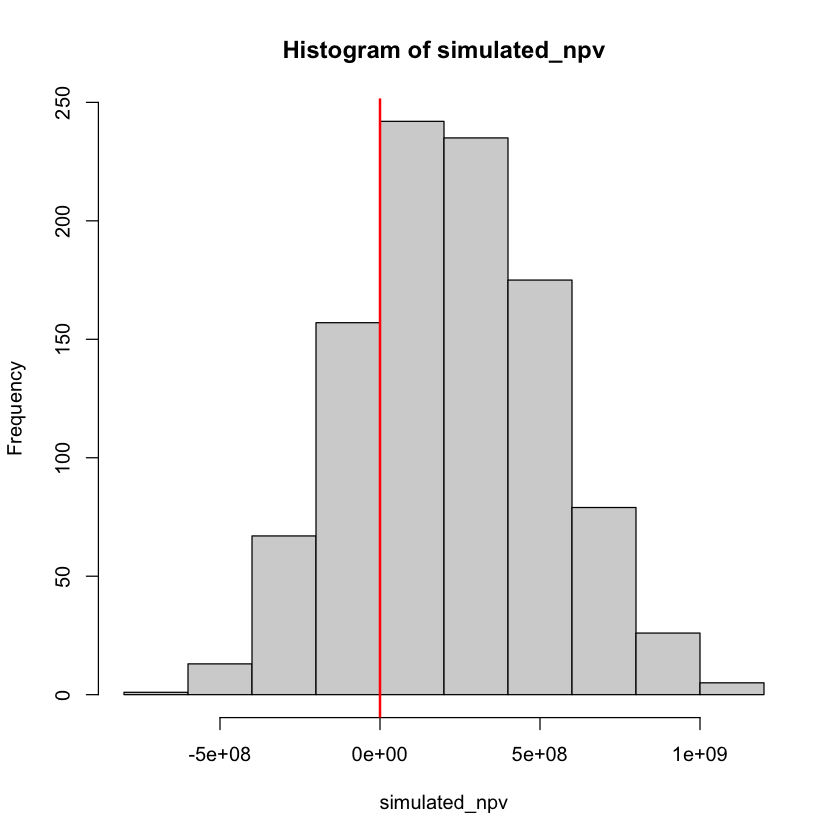

In [7]:
mean(simulated_npv<=0)
hist(simulated_npv)
abline(v = 0, col = "red", lwd = 2)

## Optimizing Purchase Quantity

Use the Newsvendor Model to set up and run a Monte Carlo simulation assuming that demand is Poisson with a mean of 40 per day.

Suggest the optimal purchase quantity when the cost per unit (C) is \\$12, the selling price (R) is \\$18, and the salvage value (S) is \\$10.

First we need to define our net profit model, which can be calculated as:

\\$Net profit = R x min(Q,D) + S x max(0,Q-D)-C x Q\\$

Where Q is our quantity to be purchased, i.e. the decision variable.

In [17]:
# Data
R = 18  # Selling price
C = 12  # Cost
S = 10   # Discount Price

# Model
# D = Units demanded
# Q = Quantity to be purchased (decision variables)
netProfitFun = function(D, Q, R, S, C){
  R*min(D,Q) + S * max(0, Q-D) - C*Q
}

We are told that the demand is a Poisson distribution with a mean of 40 per day. It would be easy to assume that means our Q is 40, but we will test this by creating simulating the distribution and evaluating our mean for each potential Q in a range of 40-50.

Qrange,profit_for_each_Q
40,221.768
41,223.400
42,224.560
43,225.232
44,225.440
45,225.248
46,224.704
47,223.808
48,222.688
49,221.376


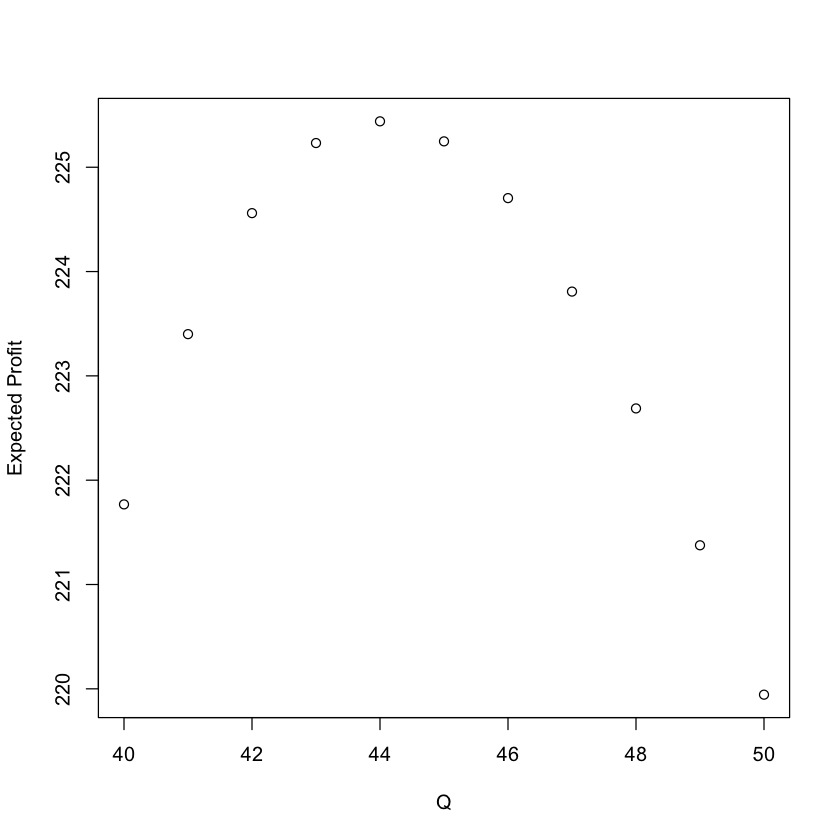

In [19]:
num_sim = 1000

Qrange = 40:50

sim_D <- rpois(num_sim, lambda = 40) 

profitMatrix <- matrix(nrow = num_sim, ncol = length(Qrange))

j = 0
for (Q in Qrange) {
  j = j+1
  for (i in 1:num_sim) {
    profitMatrix[i, j] = netProfitFun(sim_D[i], Q, R, S, C)  
  }
}

# Expected profit for each Q
profit_for_each_Q <- colMeans(profitMatrix)

cbind(Qrange, profit_for_each_Q)

plot(Qrange, colMeans(profitMatrix), ylab = "Expected Profit", xlab = "Q")

By looking at our column means for the simulated values at each Q, we actually see that 44 is the optimal purchasing quantity as this is visible as the peak on our plot.